
# The Milwaukee Journal Sentinel and pothole fill times

**Story:** [Race gap found in pothole patching](https://web.archive.org/web/20081223094123/http://www.jsonline.com/news/milwaukee/32580034.html)

**Author:** Keegan Kyle, Grant Smith and Ben Poston, Milwaukee Journal Sentinel

**Topics:** Census Data, Geocoding, QGIS Spatial Joins, Linear Regression

**Datasets**

* **potholes-cleaned-merged.csv:** a series of merged datasets (minus the income dataset). The datasets include:
    - **2007-2010 POTHOLES.xls**: Pothole data, July 2007-July 2010 from the Milwaukee [DPW](https://city.milwaukee.gov/dpw)
    - **2010-2013 POTHOLES.xls**: Pothole data, July 2010-July 2013 from the Milwaukee [DPW](https://city.milwaukee.gov/dpw)
    - **2013-2017 POTHOLES.xls**: Pothole data, July 2013-July 2017 from the Milwaukee [DPW](https://city.milwaukee.gov/dpw)
    - **tl_2013_55_tract.zip:** 2013 census tract boundaries from the [US Census Bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php)
    - **addresses_geocoded.csv:** a large selection of addresses in Milwaukee, geocoded by [Geocod.io](https://geocod.io)
    - **R12216099_SL140.csv:** ACS 2013 5-year, tract level, from [Social Explorer](https://www.socialexplorer.com)
        - Table A04001, Hispanic or Latino by Race, data dictionary is [here](https://www.socialexplorer.com/data/ACS2013_5yr/metadata/?ds=SE&table=A04001)
* **R12216226_SL140.csv** ACS 2013 5-year, tract level, from [Social Explorer](https://www.socialexplorer.com)
    - Table A14006, 2013 Median Household income
    - Data dictionary [is here](https://www.socialexplorer.com/data/ACS2013_5yr/metadata/?ds=SE&table=A14006)

# What's the story?

We're trying to figure out if the **time it took Milwaukee to fill pot holes** is related to the racial makeup of a census tract.

# Do your imports

You'll also want to set pandas to display **up to 200 columns at a time**.

In [74]:
!ls

Homework-Potholes (incomplete).ipynb R12216226_SL140.csv
R12216099_SL140.csv                  potholes-cleaned-merged.csv


In [75]:
import pandas as pd

pd.set_option("display.max_columns", 200)
df = pd.read_csv(
    "potholes-cleaned-merged.csv",
    dtype={'GEOID': 'str', 'Geo_FIPS': 'str'},
    parse_dates=['EnterDt', 'ResolvDt']
)
df.head()

,address,GEOID,Geo_FIPS,SE_A04001_001,SE_A04001_002,SE_A04001_003,SE_A04001_004,SE_A04001_005,SE_A04001_006,SE_A04001_007,SE_A04001_008,SE_A04001_009,SE_A04001_010,SE_A04001_011,SE_A04001_012,SE_A04001_013,SE_A04001_014,SE_A04001_015,SE_A04001_016,SE_A04001_017,A,Street,EnterDt,PrintDt,ResolvDt
0,1400 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00
1,1228 E JUNEAU AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00
2,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-03-12 21:00:00,2013-03-13 06:13,2013-03-15 15:38:00
3,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-12-27 09:10:00,2013-12-30 06:00,2013-12-30 13:38:00
4,1230 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1230,N PROSPECT AV,2013-11-25 22:45:00,2013-11-26 06:18,2013-11-26 14:40:00


# Read in your data

We're just reading in `potholes-cleaned-merged.csv` for now. It's a lot lot lot of other files, somewhat cleaned and all merged together.

* **Tip:** Both `GEOID` and `Geo_FIPS` are census tract identifiers. You'll want to read them in as strings so they don't lose leading zeroes

## What is the maximum and minimum `EnterDt` and `ResolvDt`?

Use this to confirm that your date range is what you expected. If it isn't, take a look at what might have happened with your dataset.

* **Tip:** Missing data might be a headache

In [76]:
df.EnterDt.min()


Timestamp('2013-01-02 06:31:00')

In [77]:
df.EnterDt.max()

Timestamp('2013-12-31 17:06:00')

In [78]:
df.ResolvDt.dropna().min()

Timestamp('2013-01-02 06:33:00')

In [79]:
df.ResolvDt.dropna().max()

Timestamp('2014-01-23 17:05:00')

In [80]:
df.dtypes

address                  object
GEOID                    object
Geo_FIPS                 object
SE_A04001_001             int64
SE_A04001_002             int64
SE_A04001_003             int64
SE_A04001_004             int64
SE_A04001_005             int64
SE_A04001_006             int64
SE_A04001_007             int64
SE_A04001_008             int64
SE_A04001_009             int64
SE_A04001_010             int64
SE_A04001_011             int64
SE_A04001_012             int64
SE_A04001_013             int64
SE_A04001_014             int64
SE_A04001_015             int64
SE_A04001_016             int64
SE_A04001_017             int64
A                         int64
Street                   object
EnterDt          datetime64[ns]
PrintDt                  object
ResolvDt         datetime64[ns]
dtype: object

## Calculate how long it took to fill potholes in 2013

Save it into a new column.

* **Tip:** It's possible to subtract two dates

In [81]:
# df.EnterDt
# df.ResolvDt
df['wait_dt'] = df.ResolvDt - df.EnterDt
df.head()

,address,GEOID,Geo_FIPS,SE_A04001_001,SE_A04001_002,SE_A04001_003,SE_A04001_004,SE_A04001_005,SE_A04001_006,SE_A04001_007,SE_A04001_008,SE_A04001_009,SE_A04001_010,SE_A04001_011,SE_A04001_012,SE_A04001_013,SE_A04001_014,SE_A04001_015,SE_A04001_016,SE_A04001_017,A,Street,EnterDt,PrintDt,ResolvDt,wait_dt
0,1400 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00,1 days 02:27:00
1,1228 E JUNEAU AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00,4 days 18:38:00
2,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-03-12 21:00:00,2013-03-13 06:13,2013-03-15 15:38:00,2 days 18:38:00
3,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-12-27 09:10:00,2013-12-30 06:00,2013-12-30 13:38:00,3 days 04:28:00
4,1230 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1230,N PROSPECT AV,2013-11-25 22:45:00,2013-11-26 06:18,2013-11-26 14:40:00,0 days 15:55:00


### Hrm, well, I think we need that difference to be an integer

If your new column isn't an integer, create _another_ column that is.

* **Tip:** Just like you might use `.str.strip()` on a string column, if your column is a datetime you can use `.dt.components` to get the days, hours, minutes, seconds, etc of the column.

In [82]:
# Instead of 4 days and 18 hours, we want like 4.75 days (or whatever)
df['wait_days'] = df.wait_dt.dt.components.days + df.wait_dt.dt.components.hours / 24

In [83]:
df.wait_days.describe()

count    12813.000000
mean         8.524324
std         12.189399
min          0.000000
25%          1.083333
50%          3.666667
75%         10.625000
max         95.208333
Name: wait_days, dtype: float64

## Cleaning up your census data

The `SE_` columns are all from the census data, you can find out what they mean by reading the data dictionary [on the Census Explorer website](https://www.socialexplorer.com/data/ACS2013_5yr/metadata/?ds=SE&table=A04001).

Add new columns to create:

* `pct_white` The percent of the population that is White
* `pct_black` The percent of the population that is Black
* `pct_hispanic` The percent of the population that is Hispanic
* `pct_minority` The percent of the population that is a minority (non-White)

The column names don't match exactly, but you can figure it out.

In [94]:
df['pct_white'] = df.SE_A04001_003 / df.SE_A04001_001
df['pct_black'] = df.SE_A04001_004 / df.SE_A04001_001
df['pct_hisp'] = df.SE_A04001_010 / df.SE_A04001_001
df['pct_minority'] = 100 - (df.pct_white*100)
df.head()

,address,GEOID,Geo_FIPS,SE_A04001_001,SE_A04001_002,SE_A04001_003,SE_A04001_004,SE_A04001_005,SE_A04001_006,SE_A04001_007,SE_A04001_008,SE_A04001_009,SE_A04001_010,SE_A04001_011,SE_A04001_012,SE_A04001_013,SE_A04001_014,SE_A04001_015,SE_A04001_016,SE_A04001_017,A,Street,EnterDt,PrintDt,ResolvDt,wait_dt,wait_days,pct_white,pct_black,pct_hisp,pct_minority
0,1400 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00,1 days 02:27:00,1.083333,0.747351,0.09114,0.053412,25.264943
1,1228 E JUNEAU AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00,4 days 18:38:00,4.750000,0.747351,0.09114,0.053412,25.264943
2,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-03-12 21:00:00,2013-03-13 06:13,2013-03-15 15:38:00,2 days 18:38:00,2.750000,0.747351,0.09114,0.053412,25.264943
3,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-12-27 09:10:00,2013-12-30 06:00,2013-12-30 13:38:00,3 days 04:28:00,3.166667,0.747351,0.09114,0.053412,25.264943
4,1230 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1230,N PROSPECT AV,2013-11-25 22:45:00,2013-11-26 06:18,2013-11-26 14:40:00,0 days 15:55:00,0.625000,0.747351,0.09114,0.053412,25.264943


# HOMEWORK STARTS HERE

# Linear regression

Using the `statsmodels` package, run a linear regression to find the coefficient relating percent minority and pothole fill times.

In [95]:
import statsmodels.formula.api as smf

model = smf.ols('wait_days ~ pct_minority', data=df)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_days   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     126.4
Date:                Fri, 19 Feb 2021   Prob (F-statistic):           3.49e-29
Time:                        09:24:27   Log-Likelihood:                -50049.
No. Observations:               12783   AIC:                         1.001e+05
Df Residuals:                   12781   BIC:                         1.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.0386      0.247     24.489      0.000       5.555       6.522
pct_minority     0.0396      0.004     11.242      0.000       0.033       0.047
==============================================================================
Omnibus:                     6385.090   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37480.668
Skew:                           2.405   Prob(JB):                         0.00
Kurtosis:                       9.873   Cond. No.                         161.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the regression summary, **did this regression do a good job?** Can you trust it? Why or why not?

*Note: This could have plenty of completely different answers!*

Using the R-squared metric, it seems that the regression does not do a good job. R-squared in this instance shows that 1% of pothole wait times can be explained by the percentage of minorities in a given neighborhood. The adjust r-squared value does not indicate a stronger relationship. 

Translate the coefficient into the form **"every X percentage point change in the minority population translates to a Y change in pot hole fill times"**

For every one percentage point increase in the percent minority population, the number of wait days increases by 4.

Pay attention to units that you're looking at --> wait days measured in days, pop in %

Let's do a **sanity check:** does that relationship make sense? Does that seem reasonable?

The scale is wrong, percent minority doesn't go from 0-100, it's 0-1. So we convert the pop numbers into units of 100 to make a more coherent regression. 

Let's be honest: **probably not.** Take a look at your inputs and outputs and explain...

1. what went wrong and
2. how to fix it.

If you need to re-run the regression, do so below. If you can answer without re-running it, you can just explain what happened and rephrase the result.

But when we get the new regression, muliply by 24 so it makes sense:

In [73]:
24 * 0.04 #about an hour

0.96

<AxesSubplot:xlabel='pct_minority', ylabel='wait_days'>

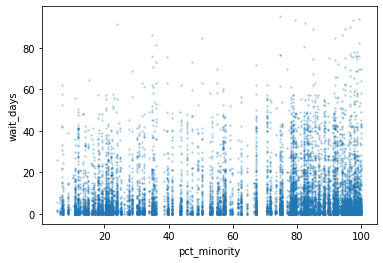

In [96]:
df.plot(x='pct_minority', y='wait_days', kind = 'scatter', alpha=0.25, s=2)

# Other methods of explanation

While the regression is technically correct, it just does't sound very nice. What other options do we have?

## What's the average wait to fill a pothole between majority-white and majority-minority census tracts?

You'll need to create a new column to specify whether the census tract is majority White or not.

In [109]:
import numpy as np

In [110]:
df['majority_white'] = np.where(df['pct_white'] > df['pct_minority'], True, False)
df.head()

,address,GEOID,Geo_FIPS,SE_A04001_001,SE_A04001_002,SE_A04001_003,SE_A04001_004,SE_A04001_005,SE_A04001_006,SE_A04001_007,SE_A04001_008,SE_A04001_009,SE_A04001_010,SE_A04001_011,SE_A04001_012,SE_A04001_013,SE_A04001_014,SE_A04001_015,SE_A04001_016,SE_A04001_017,A,Street,EnterDt,PrintDt,ResolvDt,wait_dt,wait_days,pct_white,pct_black,pct_hisp,pct_minority,maj_white_other,pct_minority_100,census_group,majority_white
0,1400 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00,1 days 02:27:00,1.083333,0.747351,0.09114,0.053412,25.264943,1,2526.494277,NaN,False
1,1228 E JUNEAU AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00,4 days 18:38:00,4.750000,0.747351,0.09114,0.053412,25.264943,1,2526.494277,NaN,False
2,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-03-12 21:00:00,2013-03-13 06:13,2013-03-15 15:38:00,2 days 18:38:00,2.750000,0.747351,0.09114,0.053412,25.264943,1,2526.494277,NaN,False
3,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-12-27 09:10:00,2013-12-30 06:00,2013-12-30 13:38:00,3 days 04:28:00,3.166667,0.747351,0.09114,0.053412,25.264943,1,2526.494277,NaN,False
4,1230 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1230,N PROSPECT AV,2013-11-25 22:45:00,2013-11-26 06:18,2013-11-26 14:40:00,0 days 15:55:00,0.625000,0.747351,0.09114,0.053412,25.264943,1,2526.494277,NaN,False


In [111]:
df['maj_white_other'] = (df.pct_white > .50).astype(int)
df.head()
df.groupby('maj_white_other').wait_days.describe()

,count,mean,std,min,25%,50%,75%,max
maj_white_other,,,,,,,,
0,8401.0,9.389190,12.852955,0.0,1.208333,4.166667,12.083333,95.208333
1,4412.0,6.877512,10.622321,0.0,1.000000,2.750000,7.645833,91.750000


In [112]:
df[df['majority_white'] == True].wait_days.mean()

nan

In [113]:
df[df['majority_white'] == False].wait_days.mean()

8.524324254012852

## How does the average wait time to fill a pothole change as more minorities live in an area?

Instead of doing a regression, which looks at the relationship of the *exact percent of minorities*, we could also put each census tract into a group. For example, 0-10% minorities, 10-20% minorities, etc. To do this, you use `pd.cut`:

```python
pd.cut(df.pct_minority, bins=range(0,101,20))
```

The code above creates bins between 0-100 that are 20 percentage points wide (you need to go to `101` because `range` doesn't include the last number), and finds out which bin each row is in.

**Assign this to a new column in your dataframe, and find the average wait time for each group.**

In [116]:
df['pct_minority_100'] = df.pct_minority

In [117]:
df['census_group'] = pd.cut(df.pct_minority_100, bins=range(0,101,20))
df.head()

,address,GEOID,Geo_FIPS,SE_A04001_001,SE_A04001_002,SE_A04001_003,SE_A04001_004,SE_A04001_005,SE_A04001_006,SE_A04001_007,SE_A04001_008,SE_A04001_009,SE_A04001_010,SE_A04001_011,SE_A04001_012,SE_A04001_013,SE_A04001_014,SE_A04001_015,SE_A04001_016,SE_A04001_017,A,Street,EnterDt,PrintDt,ResolvDt,wait_dt,wait_days,pct_white,pct_black,pct_hisp,pct_minority,maj_white_other,pct_minority_100,census_group,majority_white
0,1400 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00,1 days 02:27:00,1.083333,0.747351,0.09114,0.053412,25.264943,1,25.264943,"(20, 40]",False
1,1228 E JUNEAU AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00,4 days 18:38:00,4.750000,0.747351,0.09114,0.053412,25.264943,1,25.264943,"(20, 40]",False
2,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-03-12 21:00:00,2013-03-13 06:13,2013-03-15 15:38:00,2 days 18:38:00,2.750000,0.747351,0.09114,0.053412,25.264943,1,25.264943,"(20, 40]",False
3,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-12-27 09:10:00,2013-12-30 06:00,2013-12-30 13:38:00,3 days 04:28:00,3.166667,0.747351,0.09114,0.053412,25.264943,1,25.264943,"(20, 40]",False
4,1230 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1230,N PROSPECT AV,2013-11-25 22:45:00,2013-11-26 06:18,2013-11-26 14:40:00,0 days 15:55:00,0.625000,0.747351,0.09114,0.053412,25.264943,1,25.264943,"(20, 40]",False


How do the median and mean change as the percentage of minorities changes?

In [118]:
df.groupby('census_group').wait_days.median()

census_group
(0, 20]      2.208333
(20, 40]     2.916667
(40, 60]     3.270833
(60, 80]     4.291667
(80, 100]    4.250000
Name: wait_days, dtype: float64

In [119]:
df.groupby('census_group').wait_days.mean()

census_group
(0, 20]      6.141365
(20, 40]     6.988483
(40, 60]     8.644236
(60, 80]     9.533864
(80, 100]    9.504474
Name: wait_days, dtype: float64

If you feel like it, make a graph showing the change.

<AxesSubplot:xlabel='census_group'>

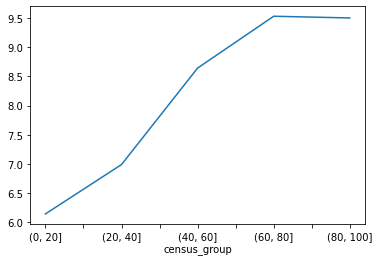

In [120]:
df.groupby('census_group').wait_days.mean().plot()

# Analyzing Income

`R12216226_SL140.csv` contains income data for each census tract in Wisconsin. We're going to add it into our analysis by merging it with our dataframe.

* **Tip:** Be sure to read in `Geo_FIPS` as a string so leading zeroes don't get removed. See how we did that up top!
* **Tip:** You can use [this data dictionary](https://www.socialexplorer.com/data/ACS2013_5yr/metadata/?ds=SE&table=A14006) to understand what column you're interested in.

In [48]:
df1 = pd.read_csv("R12216226_SL140.csv")
df1['Geo_FIPS'] = df1.Geo_FIPS.astype('str')
df.dtypes

address                      object
GEOID                        object
Geo_FIPS                     object
SE_A04001_001                 int64
SE_A04001_002                 int64
SE_A04001_003                 int64
SE_A04001_004                 int64
SE_A04001_005                 int64
SE_A04001_006                 int64
SE_A04001_007                 int64
SE_A04001_008                 int64
SE_A04001_009                 int64
SE_A04001_010                 int64
SE_A04001_011                 int64
SE_A04001_012                 int64
SE_A04001_013                 int64
SE_A04001_014                 int64
SE_A04001_015                 int64
SE_A04001_016                 int64
SE_A04001_017                 int64
A                             int64
Street                       object
EnterDt              datetime64[ns]
PrintDt                      object
ResolvDt             datetime64[ns]
wait_dt             timedelta64[ns]
wait_days                   float64
pct_white                   

## Merge with your existing dataset on census tract

In [47]:
df_new = df.merge(df1, left_on = 'Geo_FIPS', right_on = 'Geo_FIPS')
df_new.head()

,address,GEOID,Geo_FIPS,SE_A04001_001,SE_A04001_002,SE_A04001_003,SE_A04001_004,SE_A04001_005,SE_A04001_006,SE_A04001_007,SE_A04001_008,SE_A04001_009,SE_A04001_010,SE_A04001_011,SE_A04001_012,SE_A04001_013,SE_A04001_014,SE_A04001_015,SE_A04001_016,SE_A04001_017,A,Street,EnterDt,PrintDt,ResolvDt,wait_dt,wait_days,pct_white,pct_black,pct_hisp,pct_minority,majority_white,census_group,pct_minority_100,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,Geo_STATECE,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Geo_PLACE,Geo_PLACESE,Geo_TRACT,Geo_BLKGRP,Geo_CONCIT,Geo_AIANHH,Geo_AIANHHFP,Geo_AIHHTLI,Geo_AITSCE,Geo_AITS,Geo_ANRC,Geo_CBSA,Geo_CSA,Geo_METDIV,Geo_MACC,Geo_MEMI,Geo_NECTA,Geo_CNECTA,Geo_NECTADIV,Geo_UA,Geo_UACP,Geo_CDCURR,Geo_SLDU,Geo_SLDL,Geo_VTD,Geo_ZCTA3,Geo_ZCTA5,Geo_SUBMCD,Geo_SDELM,Geo_SDSEC,Geo_SDUNI,Geo_UR,Geo_PCI,Geo_TAZ,Geo_UGA,Geo_BTTR,Geo_BTBG,Geo_PUMA5,Geo_PUMA1,SE_A14006_001
0,1400 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00,1 days 02:27:00,1.083333,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0
1,1228 E JUNEAU AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00,4 days 18:38:00,4.750000,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0
2,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-03-12 21:00:00,2013-03-13 06:13,2013-03-15 15:38:00,2 days 18:38:00,2.750000,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0
3,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-12-27 09:10:00,2013-12-30 06:00,2013-12-30 13:38:00,3 days 04:28:00,3.166667,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0
4,1230 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1230,N PROSPECT AV,2013-11-25 22:45:00,2013-11-26 06:18,2013-11-26 14:40:00,0 days 15:55:00,0.625000,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0


### Run another regression, this time including both percent minority and income

In [60]:
import statsmodels.formula.api as smf

model = smf.ols('wait_days ~ SE_A14006_001 + pct_minority', data=df_new)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_days   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     81.80
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           5.02e-36
Time:                        13:53:05   Log-Likelihood:                -50031.
No. Observations:               12783   AIC:                         1.001e+05
Df Residuals:                   12780   BIC:                         1.001e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.3484      0.656      3.581      0.000       1.063       3.634
SE_A14006_001  6.061e-05   9.98e-06      6.072      0.000     4.1e-05    8.02e-05
pct_minority      6.0734      0.495     12.274      0.000       5.104       7.043
==============================================================================
Omnibus:                     6384.723   Durbin-Watson:                   1.503
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37638.231
Skew:                           2.402   Prob(JB):                         0.00
Kurtosis:                       9.898   Cond. No.                     3.12e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.12e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### How do you feel about the income coefficient?

Try to explain what it means in normal words. What's going on here? Does it relate to what happened with `pct_minority` before?

Give yourself a minute to figure out what is going on and why it's confusing. Once you've figured it out (or if you give up), scroll down to see how we fix it.)

6.061e-05 ---> 0.000006061

### Create a new column that stands for income in $10,000 increments, and try the regression again

Instead of having each unit be *one dollar*, we'll have it be *ten thousand dollars*.

In [61]:
import statsmodels.formula.api as smf

model = smf.ols('wait_days ~ np.divide(SE_A14006_001,10000) + pct_minority', data=df_new)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_days   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     81.80
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           5.02e-36
Time:                        13:54:53   Log-Likelihood:                -50031.
No. Observations:               12783   AIC:                         1.001e+05
Df Residuals:                   12780   BIC:                         1.001e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           2.3484      0.656      3.581      0.000       1.063       3.634
np.divide(SE_A14006_001, 10000)     0.6061      0.100      6.072      0.000       0.410       0.802
pct_minority                        6.0734      0.495     12.274      0.000       5.104       7.043
==============================================================================
Omnibus:                     6384.723   Durbin-Watson:                   1.503
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37638.231
Skew:                           2.402   Prob(JB):                         0.00
Kurtosis:                       9.898   Cond. No.                         32.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Explain the coefficient in normal human-being words

"Controlling for minority population, for an X change in income, there is a Y change in how long it takes to get potholes filled."

Controlling for the percentage of minorities in an area, for every 10k more in median income, pothole fill times go up 0.6 days

Every feature you add into your regression, you're controlling for

...does that make sense? 

### Just like we did with race, bin the income levels and graph it

In [68]:
df_new['income'] = df_new['SE_A14006_001']/1000
df_new.head()

,address,GEOID,Geo_FIPS,SE_A04001_001,SE_A04001_002,SE_A04001_003,SE_A04001_004,SE_A04001_005,SE_A04001_006,SE_A04001_007,SE_A04001_008,SE_A04001_009,SE_A04001_010,SE_A04001_011,SE_A04001_012,SE_A04001_013,SE_A04001_014,SE_A04001_015,SE_A04001_016,SE_A04001_017,A,Street,EnterDt,PrintDt,ResolvDt,wait_dt,wait_days,pct_white,pct_black,pct_hisp,pct_minority,majority_white,census_group,pct_minority_100,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,Geo_STATECE,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Geo_PLACE,Geo_PLACESE,Geo_TRACT,Geo_BLKGRP,Geo_CONCIT,Geo_AIANHH,Geo_AIANHHFP,Geo_AIHHTLI,Geo_AITSCE,Geo_AITS,Geo_ANRC,Geo_CBSA,Geo_CSA,Geo_METDIV,Geo_MACC,Geo_MEMI,Geo_NECTA,Geo_CNECTA,Geo_NECTADIV,Geo_UA,Geo_UACP,Geo_CDCURR,Geo_SLDU,Geo_SLDL,Geo_VTD,Geo_ZCTA3,Geo_ZCTA5,Geo_SUBMCD,Geo_SDELM,Geo_SDSEC,Geo_SDUNI,Geo_UR,Geo_PCI,Geo_TAZ,Geo_UGA,Geo_BTTR,Geo_BTBG,Geo_PUMA5,Geo_PUMA1,SE_A14006_001,income,income_bins
0,1400 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00,1 days 02:27:00,1.083333,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0,66.875,"(0, 10]"
1,1228 E JUNEAU AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00,4 days 18:38:00,4.750000,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0,66.875,"(0, 10]"
2,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-03-12 21:00:00,2013-03-13 06:13,2013-03-15 15:38:00,2 days 18:38:00,2.750000,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0,66.875,"(0, 10]"
3,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-12-27 09:10:00,2013-12-30 06:00,2013-12-30 13:38:00,3 days 04:28:00,3.166667,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0,66.875,"(0, 10]"
4,1230 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1230,N PROSPECT AV,2013-11-25 22:45:00,2013-11-26 06:18,2013-11-26 14:40:00,0 days 15:55:00,0.625000,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0,66.875,"(0, 1

In [69]:
df_new['income_bins'] = pd.cut(df_new.income, bins=range(0,101,10))
df_new.head(50)

,address,GEOID,Geo_FIPS,SE_A04001_001,SE_A04001_002,SE_A04001_003,SE_A04001_004,SE_A04001_005,SE_A04001_006,SE_A04001_007,SE_A04001_008,SE_A04001_009,SE_A04001_010,SE_A04001_011,SE_A04001_012,SE_A04001_013,SE_A04001_014,SE_A04001_015,SE_A04001_016,SE_A04001_017,A,Street,EnterDt,PrintDt,ResolvDt,wait_dt,wait_days,pct_white,pct_black,pct_hisp,pct_minority,majority_white,census_group,pct_minority_100,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,Geo_STATECE,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Geo_PLACE,Geo_PLACESE,Geo_TRACT,Geo_BLKGRP,Geo_CONCIT,Geo_AIANHH,Geo_AIANHHFP,Geo_AIHHTLI,Geo_AITSCE,Geo_AITS,Geo_ANRC,Geo_CBSA,Geo_CSA,Geo_METDIV,Geo_MACC,Geo_MEMI,Geo_NECTA,Geo_CNECTA,Geo_NECTADIV,Geo_UA,Geo_UACP,Geo_CDCURR,Geo_SLDU,Geo_SLDL,Geo_VTD,Geo_ZCTA3,Geo_ZCTA5,Geo_SUBMCD,Geo_SDELM,Geo_SDSEC,Geo_SDUNI,Geo_UR,Geo_PCI,Geo_TAZ,Geo_UGA,Geo_BTTR,Geo_BTBG,Geo_PUMA5,Geo_PUMA1,SE_A14006_001,income,income_bins
0,1400 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00,1 days 02:27:00,1.083333,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0,66.875,"(60, 70]"
1,1228 E JUNEAU AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00,4 days 18:38:00,4.750000,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0,66.875,"(60, 70]"
2,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-03-12 21:00:00,2013-03-13 06:13,2013-03-15 15:38:00,2 days 18:38:00,2.750000,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0,66.875,"(60, 70]"
3,1346 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1346,N PROSPECT AV,2013-12-27 09:10:00,2013-12-30 06:00,2013-12-30 13:38:00,3 days 04:28:00,3.166667,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0,66.875,"(60, 70]"
4,1230 N PROSPECT AV,55079186900,55079186900,2359,2233,1763,215,0,161,0,0,94,126,126,0,0,0,0,0,0,1230,N PROSPECT AV,2013-11-25 22:45:00,2013-11-26 06:18,2013-11-26 14:40:00,0 days 15:55:00,0.625000,0.747351,0.09114,0.053412,0.252649,True,"(20, 30]",25.264943,14000US55079186900,"Census Tract 1869, Milwaukee County, Wisconsin","Census Tract 1869, Milwaukee County, Wisconsin",wi,140,0,ACSSF,5008,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,186900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66875.0,66.875,"(

## What's your verdict?

Is it race? Is it income? Some combination of the two?

In [70]:
df_new.groupby('income_bins').wait_days.mean()

income_bins
(0, 10]       2.766204
(10, 20]      8.541260
(20, 30]      8.391080
(30, 40]      9.572736
(40, 50]      8.841057
(50, 60]      7.151225
(60, 70]      6.517729
(70, 80]     10.904645
(80, 90]      3.599856
(90, 100]          NaN
Name: wait_days, dtype: float64

In [71]:
df_new.groupby('census_group').wait_days.mean()

census_group
(0, 10]       6.053267
(10, 20]      6.152223
(20, 30]      6.519817
(30, 40]      7.636497
(40, 50]      8.954940
(50, 60]      8.484919
(60, 70]      9.309343
(70, 80]      9.583149
(80, 90]     10.441137
(90, 100]     8.895846
Name: wait_days, dtype: float64

How would you use this in a story or in your investigation?

It appears to be more related to race than to income? 